Welcome Random Person! 

So I have decided to do create a simple Regression model that predicts Apple's future stock prices. I have used SciKit-Learns Support Vector Regression(SVR) and LinearRegression to perform this prediction and also determine which one performs better in this simple scenario. 

So we are going to use Quandl to pull in financial data. 

Wait a mo mo, what is Quandl? Well basically this website provides an Application Programming Interface(API) to allow you to download real stock data, in formats that is simple to process.

For all the below code to work you must have a Quandl account(it is free) and do so here https://www.quandl.com/ 

Creating an account on Quandl is quick and easy! Try it yourself!

Once you have an account, you can install Quandl for Python using "pip install quandl"
See it for yourself: https://docs.quandl.com/v1.0/docs/python-installation

In [7]:
import quandl
import pandas as pd
import os
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
%matplotlib inline

This post really did help me out when I first started reading up on Quandl:
https://medium.com/python-data/quandl-getting-end-of-day-stock-data-with-python-8652671d6661

You will find your API token when you first create an account or under the API Key category on the side menu. Just paste your key in the double-inverted-commas below

In [3]:
quandl.ApiConfig.api_key="YOUR API KEY GOES HERE"

We get a table of Apple Stock data (specified under ticker) and choose the date range. Wait for the kernel to complete the processing and Voila! Your data will be stored in the variable "data".

Note: Some of these definitions were explained based on my understanding of the quandl API as I interacted with it.

Arguments explained:
1. "WIKI/PRICES" - This will look in the "WIKI/PRICES" dataset and find what you specify under ticker
2. ticker- is a symbol, which is usually an abbreviation, which represents publicly traded shares of a particular stock (Found on Google)
3. qopts- with the column option, you can specify which column to download into your dataframe or array. 
4. date- Here we specify the date range. It seems that the 'gte' and 'lte' for greater than equal to or less than equal to.
5. paginate- When we set this to true, the data will be returned page by page so that we do not exceed call limits

In [17]:
data=quandl.get_table("WIKI/PRICES",ticker = ['AAPL'], qopts={'columns': ['date','adj_close']}, date={'gte':'2000-12-31', 'lte':'2018-09-29'}, paginate=True)

We check to see if there is any null values so that we can get rid of them. If we ignore this, it can cause errors when training the model, such as crashing the model when it trains or cause it to return wrong values(since you trained it with null or invalid values)

In [18]:
data.isnull().values.any()

False

Great there is no null values! Now we set the date to be the index of the dataframe so that pandas does not assign a column to do so

In [34]:
data.set_index('date')

,adj_close
date,
2018-03-27,168.340000
2018-03-26,172.770000
2018-03-23,164.940000
2018-03-22,168.845000
2018-03-21,171.270000
2018-03-20,175.240000
2018-03-19,175.300000
2018-03-16,178.020000
2018-03-15,178.650000


Now we plot our stock data below. Be sure to run the "%matplotlib inline" otherwise it may not show up in your notebook.

Note: When I tried just running the data.plot with only the "grid" argument, the plot did not show stock prices by date but rather by the amount of data we have. Therefore, I explicitly defined the x and y variables. Also, the grid variable is a boolean to determine whether there should be axis grid lines or not. Try setting it to "False" and see the difference! Setting it to false or leaving it out has the same impact!

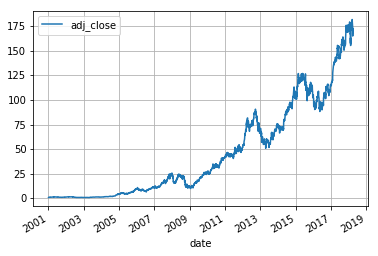

In [39]:
data.plot(x='date',y='adj_close',grid=True)

Okay so as we can see, over the years the Apple(AAPL) stock price has increased!  

Okay now we split the dataframe into features(the inputs) and labels(the expected outputs) 

In [40]:
features= np.array([(data['date'].dt.date)])
labels=np.array(data['adj_close'])

We can check the shape of the variable to determine how many values are in this array

In [41]:
features.shape

(1, 4333)

To convert the date to a form we use the toordinal() method which works on date variables. In math, an Ordinal Number is a number that tells the position of something in a list. Like 1st,2nd,3rd etc. I assume that this method converts dates to numbers into specific ranges that we chosen arbitrarily chosen by the author of this method!

In [42]:
features=[x.toordinal() for x in features[0]]

The reason why I reshaped the features variable below is that I see that I always get an error that states that a 1D input was received and the error recommends that I should reshape this variable to (-1,1). I assume that this means that to fit the model, multiple rows in this input vector is needed and that is what happens when you reshape this variable. It goes from a 4333 column varible to a 4333 row varible.

In [43]:
features=np.reshape(features, (-1,1))

Just notice the difference with the first time that we ran features.shape and the second time!

In [27]:
features.shape

(4333, 1)

We will now use sklearns train_test_split method to split the features and labels into a training set and testing set. We choose the test size to be 33% and that it should split the randomly

In [28]:
x_train, x_test, y_train, y_test=train_test_split(features, labels, test_size=0.33, random_state=42)

So we first perform linear regression and test the accuracy of such a model

In [29]:
reg=LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Hmmmmm it seems that we have 84.93% accuracy. Which is not bad, but let us see if we can get better accuracy with a different model!

In [31]:
print(reg.score(x_test, y_test))

0.849364598915366


Okay now we will try SVR, which is the regression version of Support Vector Machine(SVM).

In [32]:
svr_reg=SVR(gamma=0.1, C=1e3)
svr_reg.fit(x_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

After taking a few minutes to train the model, we find that it gives us a 95.6% accuracy. This seems great but we can do better and I will be trying to do so soon enough!

In [33]:
svr_reg.score(x_test,y_test)

0.9559730054832686

I was searching for ways to preprocess Date features and this article helped me make this decision for the STOCK MARKET SCENARIO. I am still unsure if this will work in all scenarios in which Dates are features, but it will not hurt to test this out!


References:
1. https://pdfs.semanticscholar.org/0096/f7f6b0724c5839163b0e851b12b32f8ec908.pdf

### _Please do remember that I still am learning. I have understood much of the functions based on how they perform and ofcouse, their names. So if I am wrong about a few concepts, please do let me know! I do love to learn! Also any recommendations are always welcomed!_